In [354]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split,Dataset,DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [355]:
df = pd.read_csv(r'Datasets\uber.csv')

In [356]:
df = df.dropna()

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day'] = df['pickup_datetime'].dt.dayofweek

df['distance'] = np.sqrt(
    (df['dropoff_longitude'] - df['pickup_longitude'])**2 +
    (df['dropoff_latitude'] - df['pickup_latitude'])**2
)

In [357]:
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'pickup_hour', 'pickup_day', 'distance']
target = 'fare_amount'

In [358]:
X = df[features].values
y = df[target].values

In [359]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [360]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

In [363]:
class UberDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [364]:
dataset = UberDataset(X_tensor, y_tensor)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

In [98]:
test_loader = DataLoader(test_set,batch_size=32,shuffle=True)
validation_loader = DataLoader(val_set,batch_size=32,shuffle=True)

In [1]:
class ImprovedANN(nn.Module):
    def __init__(self, input_size):
        super(ImprovedANN, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(8, 1)
        self.dropout = nn.Dropout(p=0.2)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.batch_norm2 = nn.BatchNorm1d(8)
    
    def forward(self, x):
        x = F.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

NameError: name 'nn' is not defined

In [2]:
param_grid = {
    'learning_rate': [0.01],
    'batch_size': [64],
    'epochs': [20],
}

In [372]:
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

In [373]:
best_val_loss = float('inf')
best_params = None
best_model = None

In [374]:
for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")
    
    train_loader = DataLoader(train_set, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_set, batch_size=params['batch_size'])
    
    model = ImprovedANN(input_size=len(features))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=1e-5)
    
    train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, params['epochs'])
    
    final_val_loss = val_losses[-1]
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_params = params
        best_model = model.state_dict()

Training with parameters: {'batch_size': 64, 'epochs': 20, 'learning_rate': 0.01}
Epoch 1/20, Train Loss: 83.7698, Val Loss: 102.1933
Epoch 2/20, Train Loss: 56.2530, Val Loss: 105.1117
Epoch 3/20, Train Loss: 53.0305, Val Loss: 117.2692
Epoch 4/20, Train Loss: 51.7257, Val Loss: 103.6354
Epoch 5/20, Train Loss: 50.1576, Val Loss: 111.1949
Epoch 6/20, Train Loss: 48.6723, Val Loss: 105.2621
Epoch 7/20, Train Loss: 48.3151, Val Loss: 106.1143
Epoch 8/20, Train Loss: 47.4490, Val Loss: 132.6723
Epoch 9/20, Train Loss: 46.9723, Val Loss: 107.0207
Epoch 10/20, Train Loss: 47.1287, Val Loss: 102.0421
Epoch 11/20, Train Loss: 45.8883, Val Loss: 101.7121
Epoch 12/20, Train Loss: 46.0657, Val Loss: 103.5327
Epoch 13/20, Train Loss: 44.6357, Val Loss: 102.3127
Epoch 14/20, Train Loss: 43.9726, Val Loss: 104.6891
Epoch 15/20, Train Loss: 44.7641, Val Loss: 102.3339
Epoch 16/20, Train Loss: 44.6465, Val Loss: 105.0573
Epoch 17/20, Train Loss: 44.0771, Val Loss: 103.7079
Epoch 18/20, Train Loss: 4

In [375]:
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_val_loss:.4f}")

Best parameters: {'batch_size': 64, 'epochs': 20, 'learning_rate': 0.01}
Best validation loss: 101.4966


In [376]:
test_loader = DataLoader(test_set, batch_size=32)
best_model = ImprovedANN(input_size=len(features))
best_model.load_state_dict(best_model)
best_model.eval()

TypeError: Expected state_dict to be dict-like, got <class '__main__.ImprovedANN'>.

In [377]:
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = best_model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

Test Loss: 220.0189


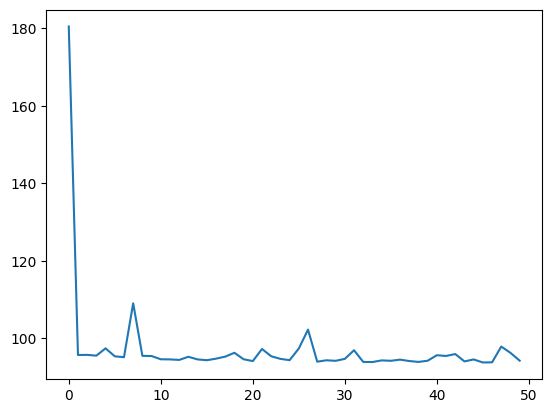

In [346]:
plt.plot(range(0,50),losses)